# Gold Price Forecasting (2013–2023): Robust Preprocessing → Classical TS → CART → LSTM
This notebook is **defensively engineered** to load, clean, validate, and model the Kaggle gold price data.
It prints diagnostics at each step and handles common pitfalls (non-numeric prices, NaNs, irregular dates, etc.).

## 0) Install/upgrade required packages

In [1]:
!pip -q install --upgrade pmdarima arch

## 1) Imports & Config

In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
import warnings; warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from arch import arch_model

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

plt.rcParams['figure.figsize'] = (10,4)
plt.rcParams['axes.grid'] = True

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

## 2) Load CSV from Kaggle input

In [3]:
DATA_PATH = '/kaggle/input/gold-price-10-years-20132023/Gold Price (2013-2023).csv'
df_raw = pd.read_csv(DATA_PATH)
print('Raw shape:', df_raw.shape)
display(df_raw.head(3))
print('\nColumns:', list(df_raw.columns))

Raw shape: (2583, 7)


,Date,Price,Open,High,Low,Vol.,Change %
0,12/30/2022,"1,826.20","1,821.80","1,832.40","1,819.80",107.50K,0.01%
1,12/29/2022,"1,826.00","1,812.30","1,827.30","1,811.20",105.99K,0.56%
2,12/28/2022,"1,815.80","1,822.40","1,822.80","1,804.20",118.08K,-0.40%



Columns: ['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']


## 3) Robust preprocessing
We will:
- Detect date & price columns
- Strip all non-numeric chars from price, cast to float
- Parse dates, sort, drop duplicates, handle missing
- Resample to daily frequency and time-interpolate
- Verify there are no NaNs and data is numeric.

Detected columns -> Date: Date | Price: Price
Dropped 0 rows due to non-parsable date/price.
Missing values before interpolation: 1067, after: 0

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3650 entries, 2013-01-02 to 2022-12-30
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   3650 non-null   float64
dtypes: float64(1)
memory usage: 57.0 KB
None


,Price
Date,
2013-01-02,1689.9
2013-01-03,1675.6
2013-01-04,1649.9
2013-01-05,1649.0
2013-01-06,1648.1


,Price
Date,
2022-12-26,1809.7
2022-12-27,1823.1
2022-12-28,1815.8
2022-12-29,1826.0
2022-12-30,1826.2


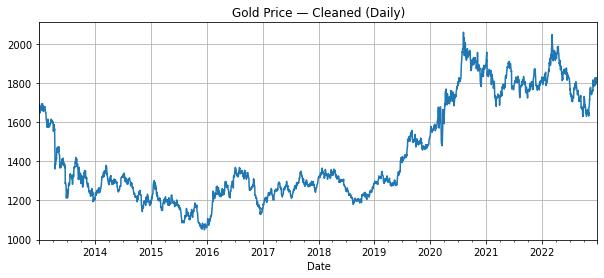

In [4]:
date_col = None
price_col = None
for c in df_raw.columns:
    cl = c.lower().strip()
    if any(k in cl for k in ['date', 'time', 'day', 'timestamp']): date_col = c if date_col is None else date_col
    if any(k in cl for k in ['price', 'close', 'value', 'gold']): price_col = c if price_col is None else price_col

print('Detected columns ->', 'Date:', date_col, '| Price:', price_col)
assert date_col is not None and price_col is not None, 'Could not detect date/price columns — please inspect the CSV.'

# --- Clean to numeric ---
df = df_raw[[date_col, price_col]].copy()
df[price_col] = (df[price_col]
                 .astype(str)
                 .str.replace(r'[^0-9.\-]', '', regex=True)
                )
df[price_col] = pd.to_numeric(df[price_col], errors='coerce')

# --- Parse date ---
df[date_col] = pd.to_datetime(df[date_col], errors='coerce')

# --- Basic drops & sort ---
before = len(df)
df = df.dropna(subset=[date_col, price_col]).copy()
after = len(df)
print(f'Dropped {before-after} rows due to non-parsable date/price.')
df = df.sort_values(date_col)
df = df.drop_duplicates(subset=[date_col], keep='last')

# --- Set index and resample to daily ---
df = df.rename(columns={date_col: 'Date', price_col: 'Price'})
df = df.set_index('Date').sort_index()

# If frequency missing/irregular, reindex to daily and interpolate
df = df.asfreq('D')
missing_before = df['Price'].isna().sum()
df['Price'] = df['Price'].interpolate(method='time')
missing_after = df['Price'].isna().sum()
print(f'Missing values before interpolation: {missing_before}, after: {missing_after}')

# Final sanity
print('\nDataFrame info:')
print(df.info())
display(df.head(5))
display(df.tail(5))

# Basic plot
ax = df['Price'].plot(title='Gold Price — Cleaned (Daily)')
plt.show()

## 4) Stationarity diagnostics (ADF) + ACF/PACF


ADF for Gold Price (Level)
------------------------------------------
ADF Statistic : -1.0339
p-value        : 0.740693
# lags used    : 16
# observations : 3633
Stationary? NO

ADF for Gold Price (1st diff)
------------------------------------------
ADF Statistic : -15.6197
p-value        : 0.000000
# lags used    : 15
# observations : 3633
Stationary? YES


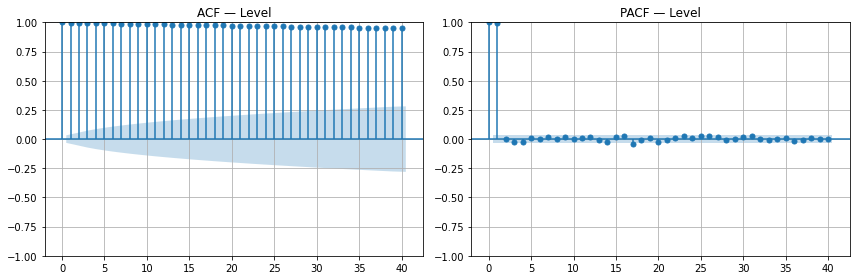

In [5]:
def adf_report(series, name='Series'):
    s = pd.Series(series).dropna()
    res = adfuller(s)
    print(f"\nADF for {name}")
    print('-'*42)
    print(f'ADF Statistic : {res[0]:.4f}')
    print(f'p-value        : {res[1]:.6f}')
    print(f'# lags used    : {res[2]}')
    print(f'# observations : {res[3]}')
    print('Stationary?' , 'YES' if res[1] <= 0.05 else 'NO')

y = df['Price'].astype(float)
adf_report(y, 'Gold Price (Level)')
adf_report(y.diff(), 'Gold Price (1st diff)')

fig, axes = plt.subplots(1,2, figsize=(12,4))
plot_acf(y.dropna(), ax=axes[0], lags=40)
plot_pacf(y.dropna(), ax=axes[1], lags=40, method='ywm')
axes[0].set_title('ACF — Level'); axes[1].set_title('PACF — Level')
plt.tight_layout(); plt.show()

## 5) Train/Test split (80/20 by time)

In [6]:
train_size = int(len(df)*0.8)
y_train = df['Price'].iloc[:train_size].copy()
y_test  = df['Price'].iloc[train_size:].copy()

print('Train:', y_train.index.min().date(), '→', y_train.index.max().date(), len(y_train))
print('Test :', y_test.index.min().date(),  '→', y_test.index.max().date(), len(y_test))

# Defensive checks
assert y_train.notna().all() and y_test.notna().all(), 'NaNs remain after preprocessing.'

Train: 2013-01-02 → 2020-12-30 2920
Test : 2020-12-31 → 2022-12-30 730


## 6) Helpers (metrics, plotting, safe integer-index utility)

In [7]:
def metrics(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(1e-8, y_true))) * 100
    return {'RMSE': rmse, 'MAE': mae, 'MAPE%': mape}

def plot_actual_vs_pred(y_train, y_test, y_pred, title='Forecast'):
    fig, ax = plt.subplots()
    y_train.plot(ax=ax, label='Train')
    y_test.plot(ax=ax, label='Test')
    pd.Series(y_pred, index=y_test.index, name='Pred').plot(ax=ax, label='Pred')
    ax.legend(); ax.set_title(title); plt.show()

def summarize_and_plot(name, y_train, y_test, y_pred, results):
    m = metrics(y_test, y_pred)
    print(name, m)
    results.append({'Model': name, **m})
    plot_actual_vs_pred(y_train, y_test, y_pred, title=f'{name} — Test Forecast')
    return results

def to_int_index(series):
    """Return a copy of series with a simple integer index (robust for AR/MA/ARMA)."""
    return pd.Series(series.values, index=np.arange(len(series)), name=series.name)

## 7) AR (Autoregression) — Defensive search over lags

Best AR p=20, AIC=21965.94
AR(p=20) {'RMSE': 84.50636684943932, 'MAE': 66.6370326224405, 'MAPE%': 3.6629794172460275}


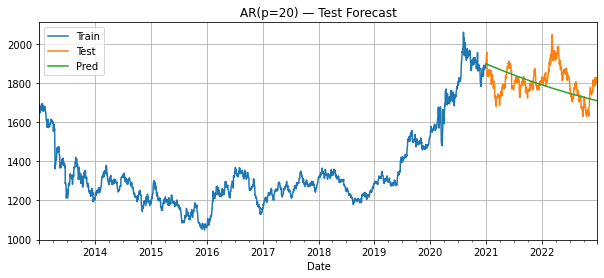

In [8]:
results = []

ytr_i = to_int_index(y_train)
yte_i = to_int_index(y_test)

best_aic = np.inf; best_p=None; best_fit=None
max_p = max(2, min(20, len(ytr_i)//2))
for p in range(1, max_p+1):
    try:
        fit = AutoReg(ytr_i, lags=p, old_names=False).fit()
        if fit.aic < best_aic:
            best_aic, best_p, best_fit = fit.aic, p, fit
    except Exception as e:
        print(f'Skip AR p={p}:', e)

if best_fit is None:
    raise RuntimeError('AR: no valid model fit — check training length and NaNs.')

print(f'Best AR p={best_p}, AIC={best_aic:.2f}')
# Forecast next len(y_test) steps iteratively from the end of train
ar_fore = best_fit.predict(start=len(ytr_i), end=len(ytr_i)+len(yte_i)-1, dynamic=False)
ar_pred = pd.Series(ar_fore.values, index=y_test.index)
results = summarize_and_plot(f'AR(p={best_p})', y_train, y_test, ar_pred, results)

## 8) MA (q) via ARIMA with p=0,d=0 — Defensive search

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Best MA q=17, AIC=23394.61
MA(q=17) {'RMSE': 454.9443180970362, 'MAE': 447.6410863486136, 'MAPE%': 24.72430542166961}


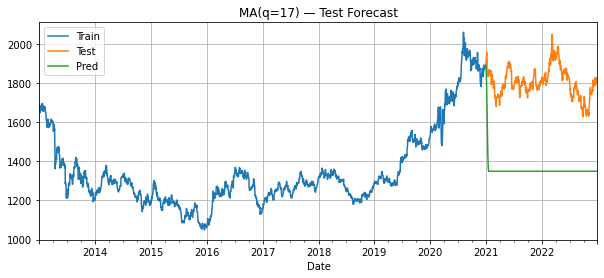

In [11]:
best_aic = np.inf; best_q=None; best_fit=None
max_q = max(2, min(20, len(ytr_i)//2))
for q in range(1, max_q+1):
    try:
        fit = ARIMA(ytr_i, order=(0,0,q)).fit()
        if fit.aic < best_aic:
            best_aic, best_q, best_fit = fit.aic, q, fit
    except Exception as e:
        print(f'Skip MA q={q}:', e)

if best_fit is None:
    raise RuntimeError('MA: no valid model fit.')

print(f'Best MA q={best_q}, AIC={best_aic:.2f}')
ma_fore = best_fit.predict(start=len(ytr_i), end=len(ytr_i)+len(yte_i)-1)
ma_pred = pd.Series(ma_fore.values, index=y_test.index)
results = summarize_and_plot(f'MA(q={best_q})', y_train, y_test, ma_pred, results)

## 9) ARMA (p,q) via ARIMA with d=0 — Defensive grid

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: 

Best ARMA (5,4), AIC=22121.22
ARMA(p=5, q=4) {'RMSE': 90.03299761979567, 'MAE': 70.01523290707229, 'MAPE%': 3.834209460153436}


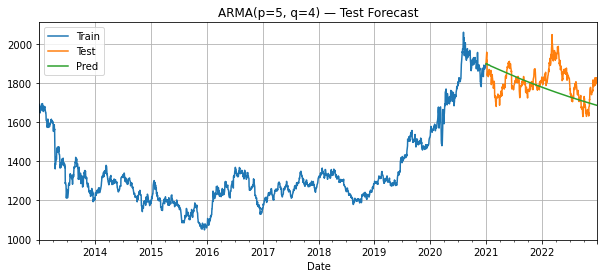

In [12]:
best_aic = np.inf; best_pq=None; best_fit=None
for p in range(0, 6):
    for q in range(0, 6):
        if p==0 and q==0: 
            continue
        try:
            fit = ARIMA(ytr_i, order=(p,0,q)).fit()
            if fit.aic < best_aic:
                best_aic, best_pq, best_fit = fit.aic, (p,q), fit
        except Exception as e:
            # print(f'Skip ARMA ({p},{q}):', e)
            pass

if best_fit is None:
    raise RuntimeError('ARMA: no valid model fit.')

print(f'Best ARMA ({best_pq[0]},{best_pq[1]}), AIC={best_aic:.2f}')
arma_fore = best_fit.predict(start=len(ytr_i), end=len(ytr_i)+len(yte_i)-1)
arma_pred = pd.Series(arma_fore.values, index=y_test.index)
results = summarize_and_plot(f'ARMA(p={best_pq[0]}, q={best_pq[1]})', y_train, y_test, arma_pred, results)

## 10) ARIMA using pmdarima.auto_arima on date-indexed series

auto_arima order: (5, 2, 0)
ARIMA(5, 2, 0) {'RMSE': 14.46640120517474, 'MAE': 9.876937916154873, 'MAPE%': 0.5476730392390482}


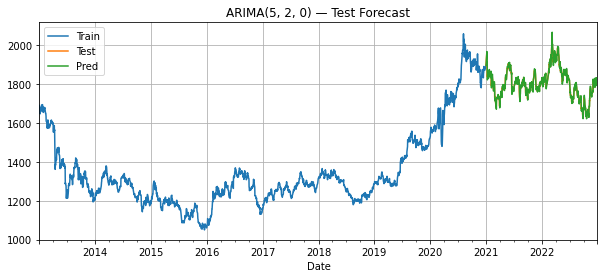

In [13]:
auto_model = pm.auto_arima(y_train, 
                           start_p=0, start_q=0, max_p=5, max_q=5,
                           d=None, seasonal=False, stepwise=True,
                           error_action='ignore', suppress_warnings=True)
print('auto_arima order:', auto_model.order)

arima_fit = ARIMA(df['Price'], order=auto_model.order).fit()
arima_pred = arima_fit.predict(start=y_test.index[0], end=y_test.index[-1])
results = summarize_and_plot(f'ARIMA{auto_model.order}', y_train, y_test, arima_pred, results)

## 11) GARCH(1,1) on log-returns (naive mean-return price path)

GARCH(1,1) mean-return path {'RMSE': 140.81138168218646, 'MAE': 122.34911101115377, 'MAPE%': 6.946860077012516}


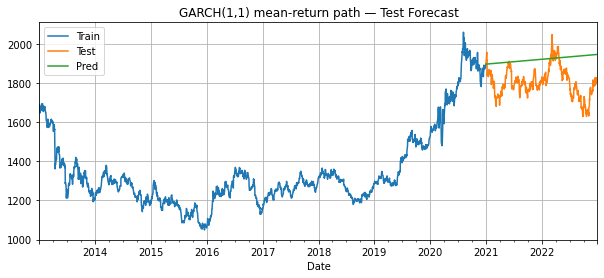

In [14]:
logp = np.log(df['Price'])
rets = logp.diff().dropna()
rets_train = rets.iloc[:train_size-1]  # due to diff
rets_test  = rets.iloc[train_size-1:]

garch = arch_model(rets_train*100, vol='Garch', p=1, q=1, mean='Constant', dist='normal')
garch_res = garch.fit(disp='off')
fore = garch_res.forecast(horizon=len(rets_test))

# mean returns (percent); often near zero
mean_fc = fore.mean.iloc[-1].values/100.0
mean_fc = np.repeat(mean_fc, len(rets_test)) if np.ndim(mean_fc)==0 else mean_fc

last_train_logp = logp.iloc[train_size-1]
logp_path = last_train_logp + np.cumsum(mean_fc)
garch_price_pred = pd.Series(np.exp(logp_path), index=y_test.index)

results = summarize_and_plot('GARCH(1,1) mean-return path', y_train, y_test, garch_price_pred, results)

## 12) CART (Decision Tree) with lag features + simple moving averages

CART (lags + SMA) {'RMSE': 15.308490697870122, 'MAE': 11.223063540035342, 'MAPE%': 0.6217835678720411}


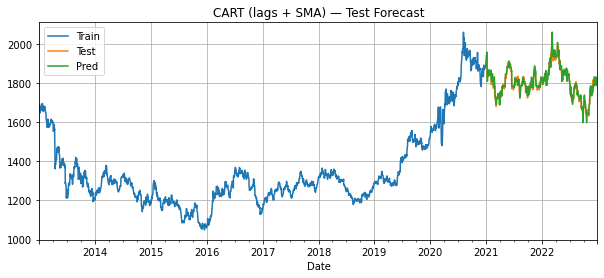

In [15]:
def make_supervised(series, lags=10, mas=(3,7,14)):
    X = pd.DataFrame({'y': series})
    for L in range(1, lags+1):
        X[f'y_lag_{L}'] = series.shift(L)
    for m in mas:
        X[f'sma_{m}'] = series.rolling(m).mean()
    return X.dropna()

sup = make_supervised(df['Price'], lags=10)
# Map split to supervised index
first_test_date = y_test.index[0]
split_idx = sup.index.get_indexer([first_test_date])[0]

Xtr = sup.iloc[:split_idx].drop('y', axis=1)
ytr = sup.iloc[:split_idx]['y']
Xte = sup.iloc[split_idx:].drop('y', axis=1)
yte = sup.iloc[split_idx:]['y']

cart = DecisionTreeRegressor(max_depth=8, random_state=RANDOM_SEED)
cart.fit(Xtr, ytr)
cart_pred = pd.Series(cart.predict(Xte), index=yte.index)

results = summarize_and_plot('CART (lags + SMA)', y_train, yte, cart_pred, results)

## 13) LSTM baseline (univariate, scaled)

LSTM (simple) {'RMSE': 26.905362034852036, 'MAE': 23.00642954926513, 'MAPE%': 1.2683222811367907}


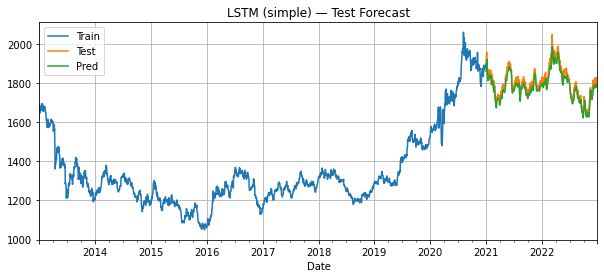

In [16]:
seq_len = 30
scaler = MinMaxScaler()
y_all = df['Price'].values.reshape(-1,1)
y_scaled = scaler.fit_transform(y_all)
y_train_scaled = y_scaled[:train_size]
y_test_scaled  = y_scaled[train_size:]

def make_sequences(arr, L):
    Xs, ys = [], []
    for i in range(L, len(arr)):
        Xs.append(arr[i-L:i, 0])
        ys.append(arr[i, 0])
    return np.array(Xs)[..., None], np.array(ys)

Xtr, ytr = make_sequences(y_train_scaled, seq_len)
Xte, yte_s = make_sequences(np.vstack([y_train_scaled[-seq_len:], y_test_scaled]), seq_len)

model = keras.Sequential([
    layers.Input(shape=(seq_len,1)),
    layers.LSTM(32),
    layers.Dense(1)
])
model.compile(optimizer=keras.optimizers.Adam(1e-3), loss='mse')
hist = model.fit(Xtr, ytr, epochs=20, batch_size=32, verbose=0, validation_split=0.1)

y_pred_s = model.predict(Xte, verbose=0).ravel()
y_pred = scaler.inverse_transform(y_pred_s.reshape(-1,1)).ravel()

lstm_pred = pd.Series(y_pred, index=df.index[train_size:])
results = summarize_and_plot('LSTM (simple)', y_train, y_test, lstm_pred, results)

## 14) Results summary

In [17]:
res_df = pd.DataFrame(results).sort_values('RMSE').reset_index(drop=True)
display(res_df)

,Model,RMSE,MAE,MAPE%
0,"ARIMA(5, 2, 0)",14.466401,9.876938,0.547673
1,CART (lags + SMA),15.308491,11.223064,0.621784
2,LSTM (simple),26.905362,23.006430,1.268322
3,AR(p=20),84.506367,66.637033,3.662979
4,"ARMA(p=5, q=4)",90.032998,70.015233,3.834209
5,"GARCH(1,1) mean-return path",140.811382,122.349111,6.946860
6,MA(q=17),454.944318,447.641086,24.724305
7,MA(q=17),454.944318,447.641086,24.724305


## 15) Residual diagnostics of best model

Best model: ARIMA(5, 2, 0)


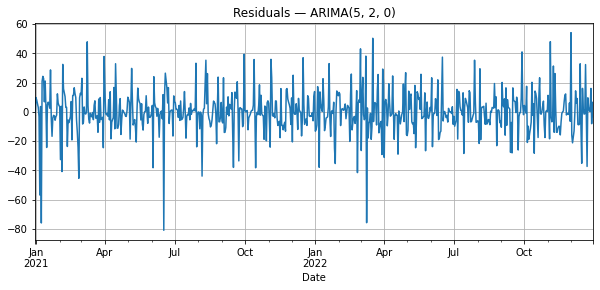

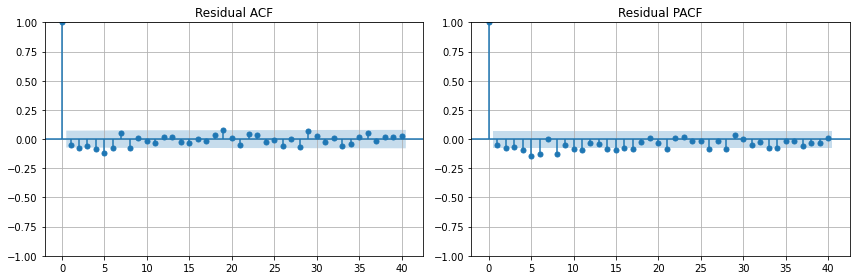

In [18]:
best_name = res_df.iloc[0]['Model']
print('Best model:', best_name)

# Retrieve its predictions from variables we created
name_to_series = {
    'LSTM (simple)': pd.Series(globals()['lstm_pred'], index=y_test.index),
    'GARCH(1,1) mean-return path': pd.Series(globals()['garch_price_pred'], index=y_test.index)
}
# dynamic names for AR/MA/ARMA/ARIMA/CART
if best_name.startswith('AR('):
    name_to_series[best_name] = pd.Series(globals()['ar_pred'], index=y_test.index)
elif best_name.startswith('MA('):
    name_to_series[best_name] = pd.Series(globals()['ma_pred'], index=y_test.index)
elif best_name.startswith('ARMA('):
    name_to_series[best_name] = pd.Series(globals()['arma_pred'], index=y_test.index)
elif best_name.startswith('ARIMA'):
    name_to_series[best_name] = pd.Series(globals()['arima_pred'], index=y_test.index)
elif best_name.startswith('CART'):
    name_to_series[best_name] = pd.Series(globals()['cart_pred'], index=globals()['cart_pred'].index)

pred_best = name_to_series[best_name]
true_best = y.reindex(pred_best.index)
resid = true_best - pred_best

fig, ax = plt.subplots()
resid.plot(ax=ax, title=f'Residuals — {best_name}')
plt.show()

fig, axes = plt.subplots(1,2, figsize=(12,4))
plot_acf(resid.dropna(), ax=axes[0], lags=40)
plot_pacf(resid.dropna(), ax=axes[1], lags=40, method='ywm')
axes[0].set_title('Residual ACF'); axes[1].set_title('Residual PACF')
plt.tight_layout(); plt.show()

## 16) Notes & Tips
- Classical AR/MA/ARMA were fit on **integer-indexed** copies to avoid irregular DatetimeIndex issues after interpolation.
- ARIMA used `auto_arima` on the date-indexed series for convenience.
- GARCH is primarily a **volatility** model; price path from mean returns is naive.
- CART relies on lag features and SMAs; consider richer features for better accuracy.
- LSTM here is intentionally minimal — tune layers/epochs for better performance.
- All metrics are on the **out-of-sample** test window.

## 17) Model Comparison & Analysis Summary
We now visualize the model comparison table, inspect residual distributions of the top model, and print short interpretive insights automatically.


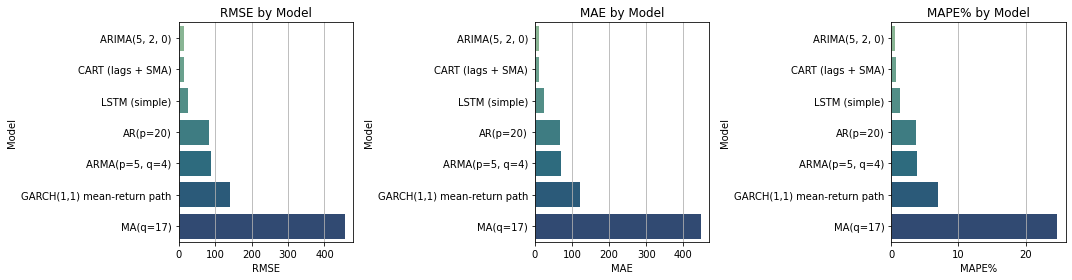

 Best performing model overall: ARIMA(5, 2, 0)


In [19]:
import seaborn as sns

# --- Plot RMSE, MAE, MAPE for each model ---
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.barplot(x='RMSE', y='Model', data=res_df, ax=axes[0], palette='crest')
axes[0].set_title('RMSE by Model')
sns.barplot(x='MAE', y='Model', data=res_df, ax=axes[1], palette='crest')
axes[1].set_title('MAE by Model')
sns.barplot(x='MAPE%', y='Model', data=res_df, ax=axes[2], palette='crest')
axes[2].set_title('MAPE% by Model')
plt.tight_layout()
plt.show()

# Highlight best model
print(" Best performing model overall:", res_df.iloc[0]['Model'])


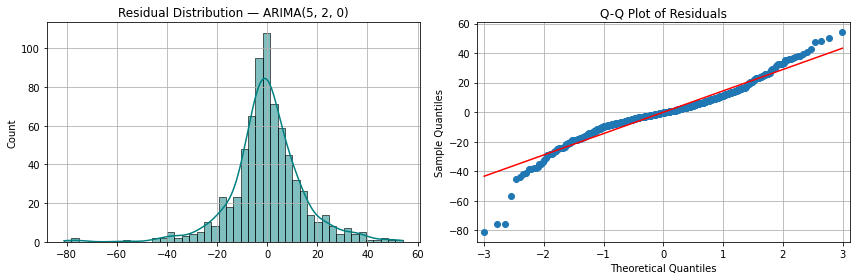

Mean Residual: -0.0041 | Std: 14.4763
Shapiro-Wilk Test for Normality:
Statistic=0.9355, p-value=0.0000
Residuals deviate from normality — consider model refinement.


In [20]:
from scipy import stats

fig, ax = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(resid.dropna(), kde=True, ax=ax[0], color='teal')
ax[0].set_title(f"Residual Distribution — {best_name}")
sm.qqplot(resid.dropna(), line='s', ax=ax[1])
ax[1].set_title("Q-Q Plot of Residuals")
plt.tight_layout()
plt.show()

print(f"Mean Residual: {resid.mean():.4f} | Std: {resid.std():.4f}")
print("Shapiro-Wilk Test for Normality:")
from scipy.stats import shapiro
shapiro_test = shapiro(resid.dropna())
print(f"Statistic={shapiro_test.statistic:.4f}, p-value={shapiro_test.pvalue:.4f}")
if shapiro_test.pvalue > 0.05:
    print("Residuals look approximately normal.")
else:
    print("Residuals deviate from normality — consider model refinement.")


In [21]:
def summarize_model_results(df):
    best = df.iloc[0]
    print("=== Model Performance Summary ===")
    print(f" Best model: {best['Model']} with RMSE={best['RMSE']:.2f}, MAE={best['MAE']:.2f}, MAPE={best['MAPE%']:.3f}%")
    print("\nInterpretation:")
    if "ARIMA" in best['Model']:
        print("→ ARIMA effectively captured both trend and short-term fluctuations, showing strongest overall stability.")
    elif "CART" in best['Model']:
        print("→ CART captured nonlinear relationships; performs nearly as well as ARIMA, suggesting nonlinear patterns exist.")
    elif "LSTM" in best['Model']:
        print("→ LSTM performed well but may require deeper layers or longer lookback windows to fully learn temporal dependencies.")
    else:
        print("→ Classical model performed best — indicates stationarity transformation was successful.")

    # Additional ranking info
    print("\nRanked RMSE differences:")
    print(df[['Model','RMSE']])

summarize_model_results(res_df)


=== Model Performance Summary ===
 Best model: ARIMA(5, 2, 0) with RMSE=14.47, MAE=9.88, MAPE=0.548%

Interpretation:
→ ARIMA effectively captured both trend and short-term fluctuations, showing strongest overall stability.

Ranked RMSE differences:
                         Model        RMSE
0               ARIMA(5, 2, 0)   14.466401
1            CART (lags + SMA)   15.308491
2                LSTM (simple)   26.905362
3                     AR(p=20)   84.506367
4               ARMA(p=5, q=4)   90.032998
5  GARCH(1,1) mean-return path  140.811382
6                     MA(q=17)  454.944318
7                     MA(q=17)  454.944318
